# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
from scipy.stats import zscore

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid') #changed seaborn to 'seaborn-v0_8-darkgrid'
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [16]:
def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    
    data = []

     # Step 1: iterate over S1, S2, ..., S10
    for subject_id in sorted(os.listdir(data_dir)):
        subject_path = os.path.join(data_dir, subject_id)
        if not os.path.isdir(subject_path):
            continue

        # Step 2: inside each subject, iterate midterm_1, midterm_2, Final
        for session in sorted(os.listdir(subject_path)):
            session_path = os.path.join(subject_path, session)
            if not os.path.isdir(session_path):
                continue

            # Load all 3 signals if available
            hr_path = os.path.join(session_path, 'HR.csv')
            eda_path = os.path.join(session_path, 'EDA.csv')
            temp_path = os.path.join(session_path, 'TEMP.csv')

            def load_signal(file_path):
                if not os.path.exists(file_path):
                    return None
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                if len(lines) < 3:
                    return None
                init_time = float(lines[0].strip())
                sample_rate = float(lines[1].strip())
                signal = np.array([float(line.strip()) for line in lines[2:]])
                timestamps = np.arange(len(signal)) / sample_rate + init_time
                return pd.DataFrame({
                    'timestamp': timestamps,
                    'value': signal
                })

            hr_df = load_signal(hr_path)
            eda_df = load_signal(eda_path)
            temp_df = load_signal(temp_path)


            merged = None
            for signal_df, col_name in zip([hr_df, eda_df, temp_df], ['heart_rate', 'eda', 'temperature']):
                if signal_df is not None:
                    if merged is None:
                        merged = signal_df.rename(columns={'value': col_name})
                    else:
                        merged = pd.merge_asof(
                            merged.sort_values('timestamp'),
                            signal_df.rename(columns={'value': col_name}).sort_values('timestamp'),
                            on='timestamp',
                            direction='nearest',
                            tolerance=1
                        )

            if merged is None:
                continue

            merged['subject_id'] = subject_id
            merged['session'] = session

            data.append(merged)

    final_df = pd.concat(data, ignore_index=True)

    final_df = final_df[['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']]

    return final_df

    pass

In [17]:
# check if the function works
df =  load_data('data')
df

,timestamp,heart_rate,eda,temperature,subject_id,session
0,1.544027e+09,116.00,0.024345,21.91,S1,Final
1,1.544027e+09,82.50,0.023064,21.93,S1,Final
2,1.544027e+09,96.33,0.023064,21.93,S1,Final
3,1.544027e+09,86.25,0.024345,21.91,S1,Final
4,1.544027e+09,98.60,0.024345,21.91,S1,Final
...,...,...,...,...,...,...
442997,1.541872e+09,159.47,0.017938,22.97,S9,midterm_2
442998,1.541872e+09,158.68,0.014094,22.97,S9,midterm_2
442999,1.541872e+09,157.72,0.015375,22.97,S9,midterm_2
443000,1.541872e+09,156.45,0.015375,22.97,S9,midterm_2


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [20]:
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    processed_data = []

    print(f"[Before] The missing data in this dataset is {data.isna().sum().sum()}")

    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

    for (subject, session), group in data.groupby(['subject_id', 'session']):
        df = group.copy().sort_values('timestamp').set_index('timestamp')

        # 1. Handle missing values (ffill and bfill)
        df[['heart_rate', 'eda', 'temperature']] = df[['heart_rate', 'eda', 'temperature']].interpolate(method='time').ffill().bfill()

        # 2. Resample to 1-second intervals
        numeric_cols = ['heart_rate', 'eda', 'temperature']
        df_numeric = df[numeric_cols].resample('1s').mean()

        df_numeric['subject_id'] = subject
        df_numeric['session'] = session
        df = df_numeric

        # 3. Remove outliers (z-score > 3.5)
        for col in ['heart_rate', 'eda', 'temperature']:
            df = df[np.abs(zscore(df[col], nan_policy='omit')) <= 3.5]

        processed_data.append(df)

    final_df = pd.concat(processed_data).reset_index()

    # Save one CSV per subject
    for subject_id, subject_df in final_df.groupby('subject_id'):
        filename = f"{subject_id}_processed.csv"
        subject_df.to_csv(os.path.join(output_dir, filename), index=False)

    print(f"[After] The missing data in this dataset is {final_df.isna().sum().sum()}")
    
    return final_df
    
    pass

In [21]:
preprocessed = preprocess_data(df)
preprocessed

[Before] The missing data in this dataset is 30
[After] The missing data in this dataset is 0


,timestamp,heart_rate,eda,temperature,subject_id,session
0,2018-12-05 16:29:07,116.00,0.024345,21.91,S1,Final
1,2018-12-05 16:29:08,82.50,0.023064,21.93,S1,Final
2,2018-12-05 16:29:09,96.33,0.023064,21.93,S1,Final
3,2018-12-05 16:29:10,86.25,0.024345,21.91,S1,Final
4,2018-12-05 16:29:11,98.60,0.024345,21.91,S1,Final
...,...,...,...,...,...,...
437931,2018-11-10 17:44:42,159.47,0.017938,22.97,S9,midterm_2
437932,2018-11-10 17:44:43,158.68,0.014094,22.97,S9,midterm_2
437933,2018-11-10 17:44:44,157.72,0.015375,22.97,S9,midterm_2
437934,2018-11-10 17:44:45,156.45,0.015375,22.97,S9,midterm_2


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [22]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Filter data
    df = data[(data['subject_id'] == subject_id) & (data['session'] == session)].copy()

    df = df.sort_values('timestamp')

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f"Physiological Signals: {subject_id} - {session}", fontsize=16)

    # Plot signals
    axes[0].plot(df['timestamp'], df['heart_rate'], label='Heart Rate', color='red')
    axes[0].set_ylabel('Heart Rate (bpm)')
    axes[0].legend()

    axes[1].plot(df['timestamp'], df['eda'], label='EDA', color='blue')
    axes[1].set_ylabel('EDA (μS)')
    axes[1].legend()

    axes[2].plot(df['timestamp'], df['temperature'], label='Temperature', color='green')
    axes[2].set_ylabel('Temperature (°C)')
    axes[2].set_xlabel('Time')
    axes[2].legend()

    # Format and save
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    filename = f"{subject_id}_{session.replace(' ', '_')}.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.close(fig)

    return fig
    
    pass

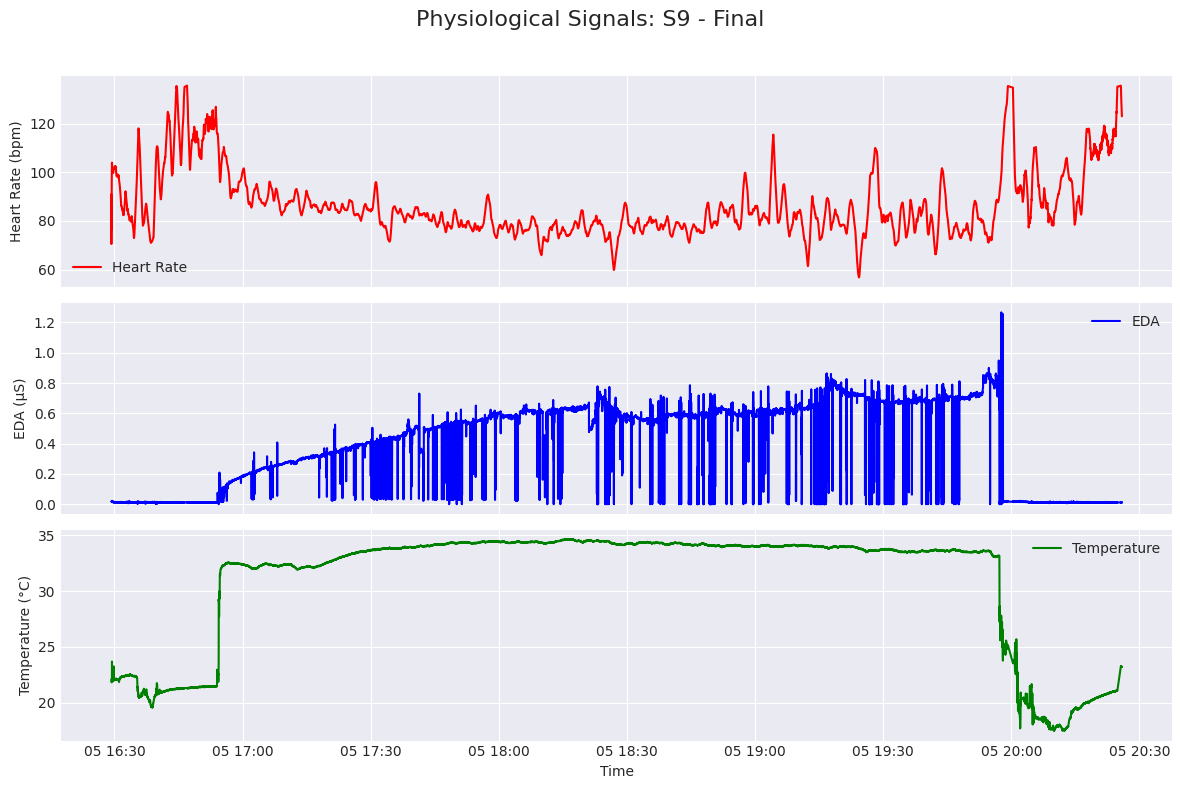

In [23]:
plot_physiological_signals(preprocessed, subject_id='S9', session='Final')


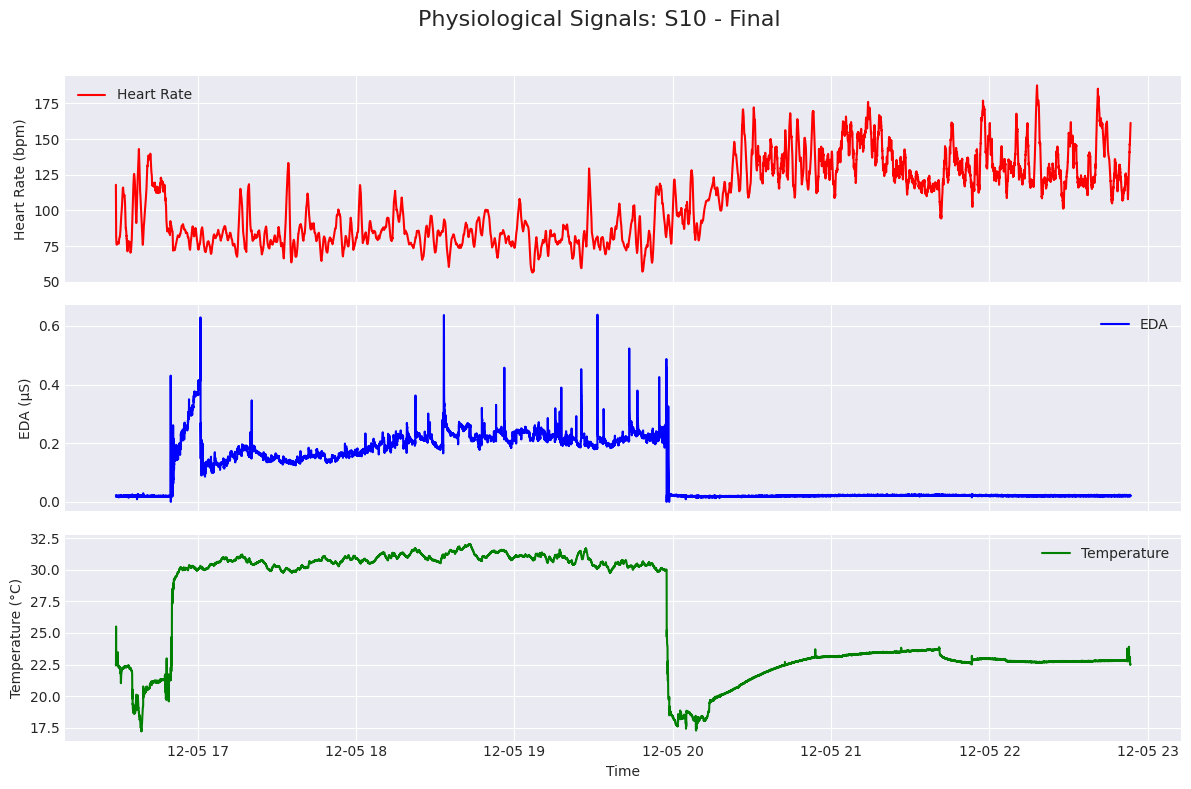

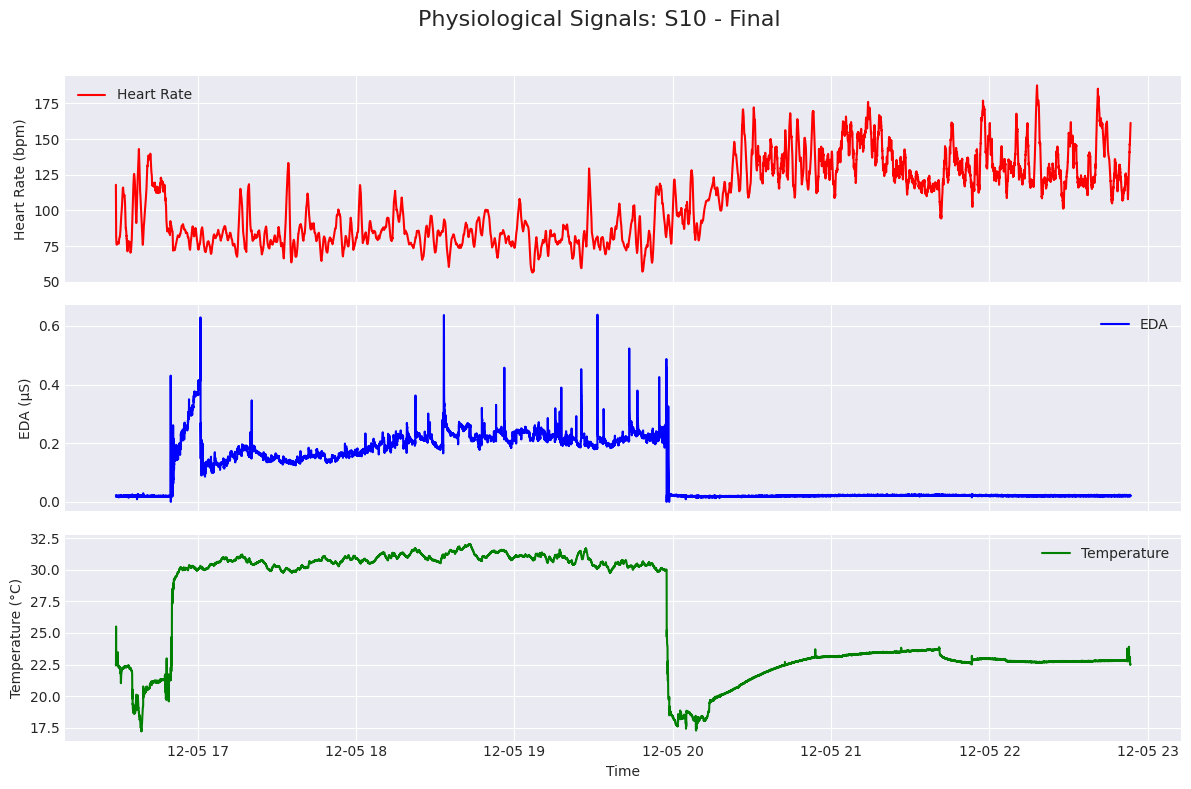

In [10]:
plot_physiological_signals(preprocessed, subject_id='S10', session='Final')